In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import random

#utils
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder


import torch
from torchmetrics.functional import r2_score

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.tuner import Tuner


from pytorch_forecasting import Baseline, DeepAR, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import RMSE, MAE, SMAPE, MultivariateNormalDistributionLoss
from pytorch_lightning.loggers import TensorBoardLogger


In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})


In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def fix_random_seeds(seed=42):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed for CPU and CUDA devices
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_random_seeds()


### 1. Импорт данных, небольшая предобработка
Для начала необходимо загрузить наш датасет и подготовить его к обучению модели. Также выполним небольшую фильтрацию данных, чтобы тратить меньше вычислительных ресурсов и быстрее выполнять эксперименты.

In [ ]:
%%time
df = pd.read_csv('/content/drive/MyDrive/diploma/full_data_sum.csv')

# Предобработаем даты к удобному формату
df['date'] = pd.to_datetime(df['date'])
df['dt'] = pd.to_datetime(df.date) + df.hour.astype('timedelta64[h]')

CPU times: user 3.62 s, sys: 407 ms, total: 4.03 s
Wall time: 10.4 s


In [ ]:
dates = sorted(df.dt.unique())
dates[0]

numpy.datetime64('2013-10-31T23:00:00.000000000')

In [ ]:
# Для создания датасета нужно перейти от значений времени к временным шагам
dates_transformer = LabelEncoder()
df['time_idx'] = dates_transformer.fit_transform(df.dt)
df['time_idx'] += 1

In [ ]:
# Категориальные переменные должны быть в строковом типе
df['square_id'] = df['square_id'].astype(str)

In [ ]:
# Разделим выборку на обучение, валидацию и тест

dates = sorted(df.date.unique())
train_dates = dates[:49]
val_dates = dates[49:-1]
test_dates = dates[-1:]

train = df[df.date.isin(train_dates)]
val = df[df.date.isin(val_dates)]
test = df[df.date.isin(test_dates)]

train_cutoff = train['time_idx'].max()
validation_cutoff = test['time_idx'].max() - 25

In [ ]:
# Для экономии ресурсов и времени выделим из датасета только те станции, которые слабо между собой коррелируют

to_select = ['internet_6974', 'internet_6554', 'internet_8966', 'internet_7445', 'internet_9361', 'internet_5557', 'internet_8847', 'internet_6875', 'internet_3862', 'internet_3527', 'internet_6274', 'internet_7155', 'internet_8087', 'internet_6071', 'internet_5445', 'internet_6745', 'internet_9986', 'internet_4349', 'internet_4972', 'internet_3234', 'internet_8045', 'internet_8380', 'internet_9877', 'internet_4639', 'internet_7987', 'internet_4657', 'internet_9398', 'internet_6077', 'internet_4478', 'internet_1684', 'internet_3958', 'internet_3258', 'internet_3554', 'internet_6754', 'internet_8176', 'internet_5473', 'internet_6846', 'internet_8502', 'internet_4144', 'internet_2247', 'internet_4664', 'internet_3957', 'internet_4973', 'internet_6472', 'internet_8046', 'internet_8242', 'internet_2145', 'internet_9778', 'internet_7552', 'internet_9869', 'internet_8958', 'internet_7055', 'internet_6836', 'internet_5451', 'internet_4040', 'internet_3532', 'internet_8891', 'internet_8757', 'internet_7167', 'internet_9150', 'internet_6467', 'internet_9474', 'internet_7154', 'internet_4345', 'internet_8558', 'internet_3928', 'internet_5443', 'internet_9785', 'internet_7424', 'internet_6664', 'internet_6546', 'internet_4830', 'internet_2654', 'internet_5245', 'internet_4128', 'internet_5368', 'internet_5447', 'internet_48', 'internet_7161', 'internet_8152', 'internet_4446', 'internet_4341', 'internet_4667', 'internet_5646', 'internet_7271', 'internet_6766', 'internet_6250', 'internet_6662', 'internet_7173', 'internet_7769', 'internet_6050', 'internet_4061', 'internet_8273', 'internet_4367', 'internet_3755', 'internet_3334', 'internet_8561', 'internet_4578', 'internet_3462', 'internet_8311', 'internet_7085', 'internet_3966', 'internet_3551', 'internet_6473', 'internet_8464', 'internet_8283', 'internet_8247', 'internet_7672', 'internet_8148', 'internet_4464', 'internet_7786', 'internet_4563', 'internet_3945', 'internet_6252', 'internet_4874', 'internet_6466', 'internet_5047', 'internet_3929', 'internet_8673', 'internet_6465', 'internet_5649', 'internet_7562', 'internet_3674', 'internet_8534', 'internet_3558', 'internet_7722', 'internet_4550', 'internet_8056', 'internet_3353', 'internet_7389', 'internet_5344', 'internet_4047', 'internet_6470', 'internet_3967', 'internet_6053', 'internet_4279', 'internet_8332', 'internet_6854', 'internet_7226', 'internet_8854', 'internet_6852', 'internet_3233', 'internet_6054', 'internet_7144', 'internet_4658', 'internet_7980', 'internet_6270', 'internet_5848', 'internet_6585', 'internet_7306', 'internet_5457', 'internet_7468', 'internet_6645', 'internet_5145', 'internet_6055', 'internet_5357', 'internet_4343', 'internet_4029', 'internet_3118', 'internet_3553', 'internet_4058', 'internet_6052', 'internet_4129', 'internet_3836', 'internet_5851', 'internet_3868', 'internet_4362', 'internet_6953', 'internet_6451', 'internet_4443', 'internet_3360', 'internet_4444', 'internet_5544', 'internet_4351', 'internet_9483', 'internet_9684', 'internet_6775', 'internet_3659', 'internet_4669', 'internet_7822', 'internet_851', 'internet_4642', 'internet_7341', 'internet_8776', 'internet_4452', 'internet_5847', 'internet_4056', 'internet_2960', 'internet_5957', 'internet_3632', 'internet_4876', 'internet_4350', 'internet_6444', 'internet_3759', 'internet_6447', 'internet_7754', 'internet_7240', 'internet_8286', 'internet_6972', 'internet_8177', 'internet_3863', 'internet_8459', 'internet_4742', 'internet_5636', 'internet_3954', 'internet_8278', 'internet_6297', 'internet_6461', 'internet_6869', 'internet_3871', 'internet_7073', 'internet_9770', 'internet_6695', 'internet_7375', 'internet_8011', 'internet_6647', 'internet_7143', 'internet_7753', 'internet_7540', 'internet_6833', 'internet_8885', 'internet_8934', 'internet_4889', 'internet_1150', 'internet_4158', 'internet_4526', 'internet_4378', 'internet_9598', 'internet_8856', 'internet_5669', 'internet_4354', 'internet_3655', 'internet_6961', 'internet_4748', 'internet_1147', 'internet_8004', 'internet_3763', 'internet_8274', 'internet_1349', 'internet_8562', 'internet_6976', 'internet_9155', 'internet_8751', 'internet_5865', 'internet_7172', 'internet_6648', 'internet_4826', 'internet_3748', 'internet_8791', 'internet_4948', 'internet_4542', 'internet_3285', 'internet_4428', 'internet_4951', 'internet_5437', 'internet_7684', 'internet_7354', 'internet_6355', 'internet_5551', 'internet_4147', 'internet_7163', 'internet_7156', 'internet_8744', 'internet_4057', 'internet_7724', 'internet_3960', 'internet_6459', 'internet_4327', 'internet_9143', 'internet_4777', 'internet_5458', 'internet_3255', 'internet_1555', 'internet_4743', 'internet_5953', 'internet_4066', 'internet_7324', 'internet_4851', 'internet_6154', 'internet_4666', 'internet_6769', 'internet_5450', 'internet_7273', 'internet_7075', 'internet_4678', 'internet_8746', 'internet_5755', 'internet_4453', 'internet_8013', 'internet_7551', 'internet_3432', 'internet_5947', 'internet_7046', 'internet_4871', 'internet_3661', 'internet_3854', 'internet_3767', 'internet_8374', 'internet_5948', 'internet_7556', 'internet_4852', 'internet_3845', 'internet_6663', 'internet_4243', 'internet_8688', 'internet_9351', 'internet_6260', 'internet_6371', 'internet_4027', 'internet_4565', 'internet_5543', 'internet_3962', 'internet_3828', 'internet_4344', 'internet_5372', 'internet_7256', 'internet_5977', 'internet_8049', 'internet_6877', 'internet_4726', 'internet_6572', 'internet_8441', 'internet_5550', 'internet_4379', 'internet_6966', 'internet_8410', 'internet_7305', 'internet_4143', 'internet_8051', 'internet_8833', 'internet_5741', 'internet_3427', 'internet_8085', 'internet_7453', 'internet_7353', 'internet_8435', 'internet_6872', 'internet_5273', 'internet_6756', 'internet_4068', 'internet_3347', 'internet_7852', 'internet_5750', 'internet_6862', 'internet_6046', 'internet_5653', 'internet_4276', 'internet_5753', 'internet_7813', 'internet_9266', 'internet_5146', 'internet_8835', 'internet_8271', 'internet_3671', 'internet_6150', 'internet_8071', 'internet_6671', 'internet_3765', 'internet_3654', 'internet_6152', 'internet_7065', 'internet_8635', 'internet_6153', 'internet_3733', 'internet_7265', 'internet_7064', 'internet_5028', 'internet_6971', 'internet_3970', 'internet_4733', 'internet_6151', 'internet_4228', 'internet_6533', 'internet_8312', 'internet_8756', 'internet_3548', 'internet_7623', 'internet_6372', 'internet_4553', 'internet_3959', 'internet_3673', 'internet_4226', 'internet_7342', 'internet_6755', 'internet_6771', 'internet_6367', 'internet_8047', 'internet_6853']
to_select = [i.split('_')[1] for i in to_select]

In [ ]:
# Также уберем станции, для которых есть пропущенные значения

broken_squares = train.groupby('square_id').time_idx.nunique()[train.groupby('square_id').time_idx.nunique() != 1153].values
train = train[~train.square_id.isin(broken_squares)]

In [ ]:
df = df[~df.square_id.isin(broken_squares)]
df = df[df.square_id.isin(to_select)]

train = train[~train.square_id.isin(broken_squares)]
train = train[train.square_id.isin(to_select)]

val = val[~val.square_id.isin(broken_squares)]
val = val[val.square_id.isin(to_select)]

test = test[~test.square_id.isin(broken_squares)]
test = test[test.square_id.isin(to_select)]

### 2. Создание TimeSeriesDataSet, DataLoader
Здесь мы подготовленные данные подаем в класс TimeSeriesDataSet, чтобы далее сделать корректный Dataloader, на котором сможем обучать модель и делать прогнозы.

In [ ]:
# Инициализируем датасеты

max_encoder_length = 60
max_prediction_length = 24


context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    train,
    time_idx="time_idx",
    target="internet",
    categorical_encoders={"square_id": NaNLabelEncoder().fit(train.square_id)},
    group_ids=["square_id"],
    static_categoricals=["square_id"], # Deep AR позволяет учитывать статичные
                                       # категориальные признаки, в нашем случае это id станции
    time_varying_unknown_reals=["internet"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    allow_missing_timesteps=False
)

validation = TimeSeriesDataSet.from_dataset(training,
                                            df,
                                            min_prediction_idx=train_cutoff + 1)


In [ ]:
# Переводим все наши датасеты в даталоадеры

batch_size = 128
train_dataloader = training.to_dataloader(
    train=True,
    batch_size=batch_size,
    num_workers=4,
    drop_last=True,
    batch_sampler="synchronized"
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=4, batch_sampler="synchronized"
)

# Выведем содержимое батча из датасета
x, y = next(iter(val_dataloader))
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

	encoder_cat = torch.Size([128, 60, 1])
	encoder_cont = torch.Size([128, 60, 1])
	encoder_target = torch.Size([128, 60])
	encoder_lengths = torch.Size([128])
	decoder_cat = torch.Size([128, 24, 1])
	decoder_cont = torch.Size([128, 24, 1])
	decoder_target = torch.Size([128, 24])
	decoder_lengths = torch.Size([128])
	decoder_time_idx = torch.Size([128, 24])
	groups = torch.Size([128, 1])
	target_scale = torch.Size([128, 2])


In [ ]:
%%time

# Сделаем еще один набор данных для быстрого обучения и валидации, куда возьмем лишь часть временных рядов
# При желании можно воспользоваться и полными датасетами

random_bs = np.random.choice(df.square_id.unique(), 150)


train_sample = TimeSeriesDataSet.from_dataset(training, train[train.square_id.isin(random_bs)])
validation_sample = TimeSeriesDataSet.from_dataset(training, val[val.square_id.isin(random_bs)], min_prediction_idx=train_cutoff + 1)


train_subset_loader = train_sample.to_dataloader(
    train=True,
    batch_size=batch_size,
    num_workers=4,
    drop_last=True,
    batch_sampler="synchronized")

val_subset_loader = validation_sample.to_dataloader(
    train=False, batch_size=batch_size, num_workers=4, batch_sampler="synchronized"
)

# Проверим, что данные внутри такие же как и в полной валидации
x, y = next(iter(val_subset_loader))
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

	encoder_cat = torch.Size([123, 60, 1])
	encoder_cont = torch.Size([123, 60, 1])
	encoder_target = torch.Size([123, 60])
	encoder_lengths = torch.Size([123])
	decoder_cat = torch.Size([123, 24, 1])
	decoder_cont = torch.Size([123, 24, 1])
	decoder_target = torch.Size([123, 24])
	decoder_lengths = torch.Size([123])
	decoder_time_idx = torch.Size([123, 24])
	groups = torch.Size([123, 1])
	target_scale = torch.Size([123, 2])
CPU times: user 552 ms, sys: 78.6 ms, total: 631 ms
Wall time: 2.61 s


### 3. Расчет бейзлайна
Для оценки качества нашей сети нам нужно ее с чем-то сравнить, воспользуемся бейзлайном в библиотеке torch forecasting.
В случае torch forecasting, Baseline - это модель, которая в качестве предсказание использует последнее известное значение временного ряда

In [ ]:
%%time
# Запишем ответы из валидации в один тензор, чтобы быстрее считать метрики
val_answers = torch.cat([y[0] for x, y in iter(val_subset_loader)]).to(DEVICE)

CPU times: user 814 ms, sys: 321 ms, total: 1.14 s
Wall time: 17.1 s


In [ ]:
%%time
# Запустим бейзлайн на валидационной выборке, а качество такого прогноза посмотрим чуть позже

baseline_predictions = Baseline().predict(val_subset_loader,
                                          trainer_kwargs=dict(accelerator=DEVICE),
                                          return_y=False)

CPU times: user 3.61 s, sys: 566 ms, total: 4.17 s
Wall time: 19.6 s


### 4. Обучение сети
Здесь с помощью фреймворка lightning мы подберем оптимальный learning_rate, укажем параметры и запустим обучение сети.

In [ ]:
pl.seed_everything(42)

trainer = pl.Trainer(accelerator=DEVICE, gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=60,
    rnn_layers=5,
    loss=MultivariateNormalDistributionLoss(rank=30),
    optimizer="Adam",
)

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.015848931924611124
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.015848931924611124
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_6fd4b068-b245-4b13-8ed0-b566bf9ccac6.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_6fd4b068-b245-4b13-8ed0-b566bf9ccac6.ckpt


suggested learning rate: 0.015848931924611124


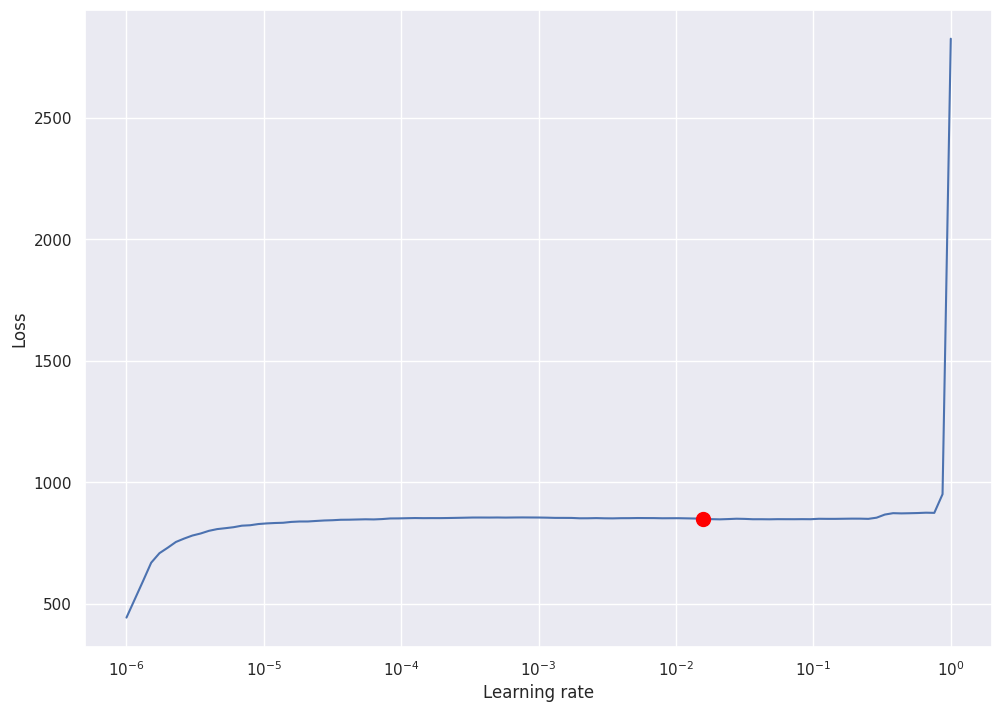

In [ ]:
res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_subset_loader,
    val_dataloaders=val_subset_loader,
    min_lr=1e-6,
    max_lr=1e0,
    early_stop_threshold=10,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [ ]:
%%time
logger = TensorBoardLogger('DeepAR_Fit', name='result_deepAR_model')

early_stop_callback = EarlyStopping(monitor="val_loss",
                                    min_delta=1e-4,
                                    patience=10,
                                    verbose=False,
                                    mode="min")
trainer = pl.Trainer(
    max_epochs=3,
    accelerator=DEVICE,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    # limit_train_batches=200,
    limit_val_batches=200,
    enable_checkpointing=True,
    logger=logger
)

trainer.fit(
    net,
    train_dataloaders=train_subset_loader,
    val_dataloaders=val_subset_loader
)

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

### 5. Валидация
Сеть обучена, пришло время оценить качество нашей модели.

In [ ]:
def evaluate(predictions, answers):
    rmse = RMSE()(predictions, answers).item()
    smape = SMAPE()(predictions, answers).item()
    mae = MAE()(predictions, answers).item()
    r2 = r2_score(predictions, answers).item()

    print(f"Evaluation Metrics:")
    print(f"RMSE: {rmse:.3f}")
    print(f"SMAPE: {smape:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R-squared: {r2:.3f}")

In [ ]:
%%time
predictions = best_model.predict(val_subset_loader,
                                 trainer_kwargs=dict(accelerator=DEVICE), )


In [ ]:
evaluate(predictions, val_answers)

In [ ]:
evaluate(baseline_predictions, val_answers)

Evaluation Metrics:
RMSE: 350.233
SMAPE: 0.339
MAE: 229.037
R-squared: 0.497


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir /content/Simpler_model

### 6. Инференс на тестовой выборке

Для инференса создадим даталоадер, куда попадут только части временных рядов, необходимые для финального прогноза.


В случае реального прогнозирования, когда у нас нет заранее известных ответов, мы могли бы заполнить датасет на N шагов вперед нулями, и также выполнить предикт

In [ ]:
test_dataset = TimeSeriesDataSet.from_dataset(training,
                                      df,
                                      min_prediction_idx=validation_cutoff + 1,
                                      predict_mode=True)

test_loader = test_dataset.to_dataloader(
    train=False, batch_size=batch_size, num_workers=4, batch_sampler="synchronized"
)


In [ ]:
test_answers = torch.cat([y[0] for x, y in iter(test_loader)]).to('cpu')

In [ ]:
raw_predictions = net.predict(test_loader, mode="prediction", return_x=True)

test_preds = raw_predictions[0].to('cpu')
x = raw_predictions[1]['encoder_target'].to('cpu')

In [ ]:
#Зафиксируем финальные метрики
evaluate(test_preds, test_answers)

In [ ]:
# Можно визуализировать отдельные прогнозы
base_station_num = 60
plt.plot(np.concatenate([x[base_station_num], test_preds[base_station_num]]), color='red')
plt.plot(np.concatenate([x[base_station_num], test_answers[base_station_num]]), color='blue')
plt.legend()

Для модели DeepAR можно выполнить и вероятностный прогноз, и получить квантили распределения прогнозируемых значений

In [ ]:
raw_predictions = net.predict(test_loader, mode="quantiles", return_x=True)
test_preds = raw_predictions[0].to('cpu')
x = raw_predictions[1]['encoder_target'].to('cpu')

Теперь мы прогнозируем по 7 значений на каждый временной шаг, давайте его тоже визуализируем!

In [ ]:
test_preds.size()

In [ ]:
base_station_num = 60
for i in range(7):
  plt.plot(np.concatenate([x[base_station_num], test_preds[base_station_num][:, i]]), color='red')
plt.plot(np.concatenate([x[base_station_num], test_answers[base_station_num]]), color='blue')
plt.legend()

Есть и встроенный вариант визуализации вероятностного прогноза

In [ ]:
raw_predictions = best_model.predict(test_loader,
                              trainer_kwargs=dict(accelerator="cpu"),
                              mode="raw", return_x=True)

test_preds = raw_predictions[0]['prediction']
x = raw_predictions[1]['encoder_target']

In [ ]:
series = test.x_to_index(raw_predictions.x)["square_id"]
for idx in range(20,30):
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")

### 7. Постпроцессинг данных

Теперь от тензоров нам нужно вернуться обратно к базовым станциям, то есть, перевести прогнозы модели к формату, в котором мы получили данные.

In [ ]:
raw_predictions = net.predict(test_loader, mode="prediction", return_x=True)
test_preds = raw_predictions[0].to('cpu')
x = raw_predictions[1]

In [ ]:
encoder = test_dataset.categorical_encoders['square_id']
ids = encoder.inverse_transform(x['decoder_cat'].to('cpu'))
time_steps = list(range(1, test_dataset.max_prediction_length+1))

result = pd.DataFrame(columns=['square_id', 'internet', 'time_idx'])
for base in tqdm(range(test.square_id.nunique())):
    base_id = ids[base]
    forecast = pd.DataFrame({'internet': test_preds[base].numpy().tolist(),
                              'square_id': [i[0] for i in base_id],
                              'time_idx': time_steps})
    result = pd.concat([result, forecast], axis=0)

In [ ]:
result